## Image가 들어있는 GCS 링크를 External Table로 생성

아래 코드 실행시 uris값 변경 필요

In [ ]:
%%bigquery
CREATE OR REPLACE EXTERNAL TABLE `qoo10.met_images`
WITH CONNECTION `jc-gcp-project.us.bigframes-rf-conn`
OPTIONS
  ( object_metadata = 'SIMPLE',
    uris = ['gs://gcs-public-data--met/*']
  );

Query is running:   0%|          |

""


In [ ]:
#@title Set up credentials
PROJECT_ID='jc-gcp-project' # 변경 필요
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
from google.cloud import bigquery
client = bigquery.Client(PROJECT_ID)

Authenticated


In [ ]:
#@title Enable data table display
%load_ext google.colab.data_table

In [ ]:
#@title Util function to display images
import io
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

def printImages(results):
 image_results_list = list(results)
 amt_of_images = len(image_results_list)

 fig, axes = plt.subplots(nrows=amt_of_images, ncols=2, figsize=(20, 20))
 fig.tight_layout()
 fig.subplots_adjust(hspace=0.5)
 for i in range(amt_of_images):
   gcs_uri = image_results_list[i][0]
   text = image_results_list[i][1]
   f = tf.io.gfile.GFile(gcs_uri, 'rb')
   stream = io.BytesIO(f.read())
   img = Image.open(stream)
   axes[i, 0].axis('off')
   axes[i, 0].imshow(img)
   axes[i, 1].axis('off')
   axes[i, 1].text(0, 0, text, fontsize=10)
 plt.show()

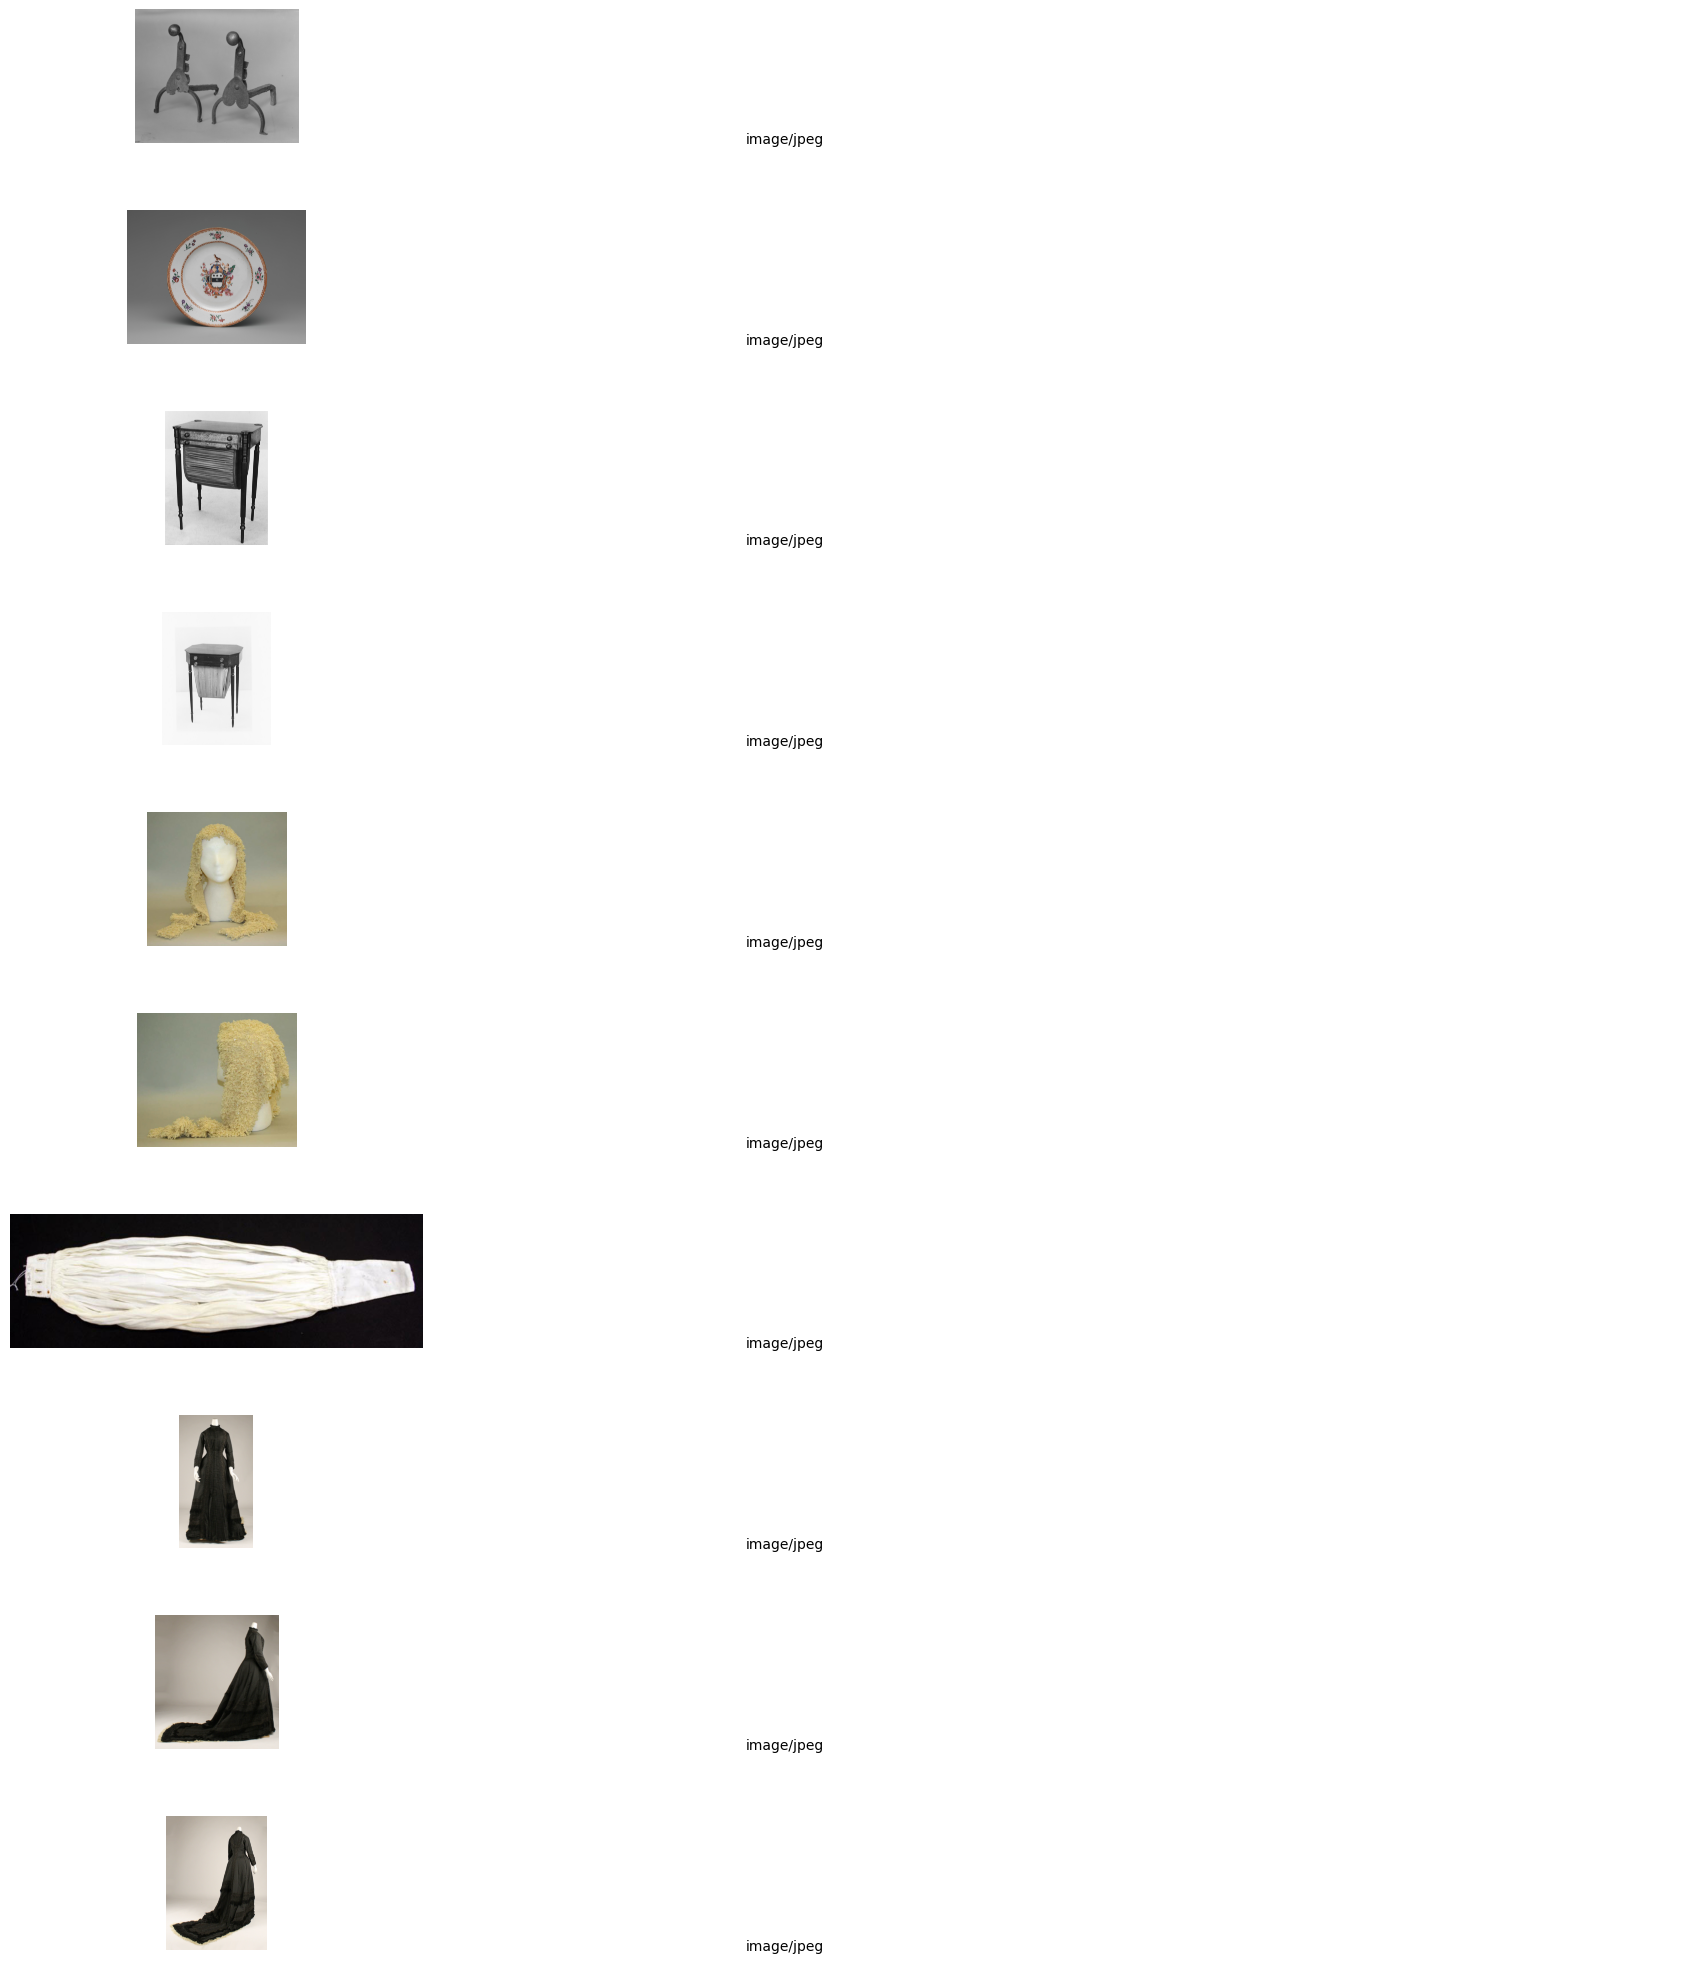

In [ ]:
#@title 이미지 샘플 확인
inspect_obj_table_query = """
SELECT uri, content_type
FROM qoo10.met_images
WHERE content_type = 'image/jpeg'
Order by uri
LIMIT 10;
"""
printImages(client.query(inspect_obj_table_query))

In [ ]:
#@title 원격 모델 만들기 (Connection 없으면 생성 필요)
%%bigquery
CREATE OR REPLACE MODEL `qoo10.multimodal_embedding_model`
  REMOTE WITH CONNECTION `jc-gcp-project.us.bigframes-rf-conn`
  OPTIONS (ENDPOINT = 'multimodalembedding@001');

Executing query with job ID: 92044ccf-3c56-4af1-863a-05ab34f12889
Query executing: 0.34s

KeyboardInterrupt: 

In [ ]:
#@title Image Embedding 생성
%%bigquery
CREATE OR REPLACE TABLE `qoo10.met_image_embeddings`
AS
SELECT *
FROM
  ML.GENERATE_EMBEDDING(
    MODEL `qoo10.multimodal_embedding_model`,
    TABLE `qoo10.met_images`)
WHERE content_type = 'image/jpeg'
LIMIT 10000;

In [ ]:
#@title 오류 체크
%%bigquery
SELECT DISTINCT(ml_generate_embedding_status),
  COUNT(uri) AS num_rows
FROM qoo10.met_image_embeddings
GROUP BY 1;

Executing query with job ID: 0c1c4dde-4805-41fe-a405-687315fd95f6
Query executing: 0.44s


ERROR:
 404 Not found: Table jc-gcp-project:qoo10.met_image_embeddings was not found in location US; reason: notFound, message: Not found: Table jc-gcp-project:qoo10.met_image_embeddings was not found in location US

Location: US
Job ID: 0c1c4dde-4805-41fe-a405-687315fd95f6



In [ ]:
#@title 발견 오류 처리
%%bigquery
DELETE FROM `qoo10.met_image_embeddings`
WHERE ml_generate_embedding_status = 'A retryable error occurred: RESOURCE_EXHAUSTED error from remote service/endpoint.';

In [ ]:
#@title Vector Indexing 진행
%%bigquery
CREATE OR REPLACE
  VECTOR INDEX `met_images_index`
ON
  qoo10.met_image_embeddings(ml_generate_embedding_result)
  OPTIONS (
    index_type = 'IVF',
    distance_type = 'COSINE');

In [ ]:
#@title Check Indexing result
%%bigquery
SELECT table_name, index_name, index_status,
  coverage_percentage, last_refresh_time, disable_reason
FROM qoo10.INFORMATION_SCHEMA.VECTOR_INDEXES
WHERE index_name = 'met_images_index';

In [ ]:
#@title Vectorize Text
%%bigquery
CREATE OR REPLACE TABLE `qoo10.search_embedding`
AS
SELECT * FROM ML.GENERATE_EMBEDDING(
  MODEL `qoo10.multimodal_embedding_model`,
  (
    SELECT '원목으로 만들어진 테이블' AS content
  )
);

In [ ]:
#@title Vectorize Text
%%bigquery
CREATE OR REPLACE TABLE `qoo10.vector_search_results` AS
SELECT base.uri AS gcs_uri, distance
FROM
  VECTOR_SEARCH(
    TABLE `qoo10.met_image_embeddings`,
    'ml_generate_embedding_result',
    TABLE `qoo10.search_embedding`,
    'ml_generate_embedding_result',
    top_k => 3);

In [ ]:
#@title Check Result
query = """
  SELECT * FROM `qoo10.vector_search_results`
  ORDER BY distance;
"""

printImages(client.query(query))